# Objective: Learn to do clustering and noise reduction in data using PCA 

In [156]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import svd 
from sklearn.datasets import load_digits

digits = load_digits()

## PCA using SVD

In [157]:
def PCA(X):
    U, S, PT = svd(X, full_matrices=False)
    Sigma = np.diag(S)
    T = np.dot(U, Sigma)
    return T, PT.T, Sigma # Score, Loadings, Variance

In [158]:
def plot_digits(data):
    fig, axes = plt.subplots(
        4, 10, figsize=(10, 4),
        subplot_kw={'xticks':[], 'yticks':[]},
        gridspec_kw=dict(hspace=0.1, wspace=0.1)
    )

    for i, ax in enumerate(axes.flat):
        ax.imshow(
            data[i].reshape(8, 8),
            cmap='binary', interpolation='nearest', clim=(0, 16)
        )

In [159]:
# Find out the original dimension of the data
X = digits.data
y = digits.target

X_standard_m = np.zeros_like(X)
for col in range(X_standard_m.shape[1]):
    X_col = X[:, col]
    X_standard_m[:, col] = (X_col - np.mean(X_col))

X = X_standard_m    

print("Shape of X", X.shape)
print("Shape of y", y.shape)

Shape of X (1797, 64)
Shape of y (1797,)


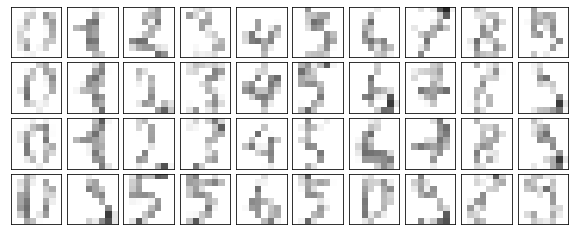

In [160]:
# Visualize the original data
plot_digits(X)

### Task 1: Dimensionality reduction: Conduct PCA on the the matrix $X$ to find out the dimension required to capture 80% of the variance

Required components/dimensions to explain 75.0% variance: 650


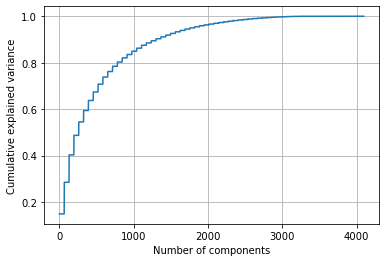

In [161]:
# TODO: Make plots comparing normalization to not
# Get variance explained by singular values
n_samples = X.shape[0]
X_normalized = X / np.linalg.norm(X, axis = 1, keepdims = True)
T, P, Sigma = PCA(X)

# Compute sample variance
explained_variance = (Sigma ** 2) / (n_samples - 1)
total_variance = explained_variance.sum()
explained_variance_ratio = explained_variance / total_variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

explained_variance_threshold = 0.75
required_dimensions = np.argmax(cumulative_explained_variance > explained_variance_threshold)

plt.plot(cumulative_explained_variance)
plt.grid()
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance');
print(f'Required components/dimensions to explain {explained_variance_threshold*100}% variance: {required_dimensions}')

Using the "eyeballing" method to pinpoint the necessary dimension to capture a given amount of variance is not very precise when the dimensionality of the underlying data is *larger than it is here*. For data sets with eg. 100+ dimensions we could solve for the exact dimension that exceeds the set explained variance, say 80%, as

```
cumulative_explained = np.cumsum(explained_variance_ratio)
n_required_dims = np.argmax(cumulative_explained > 0.8)
```  
We can also specify the required amount of explained variance if we use e.g. sklearn's PCA implementation.

###  Task 2: Clustering: Project the original data matrix X on the first two PCs and draw the scalar plot 

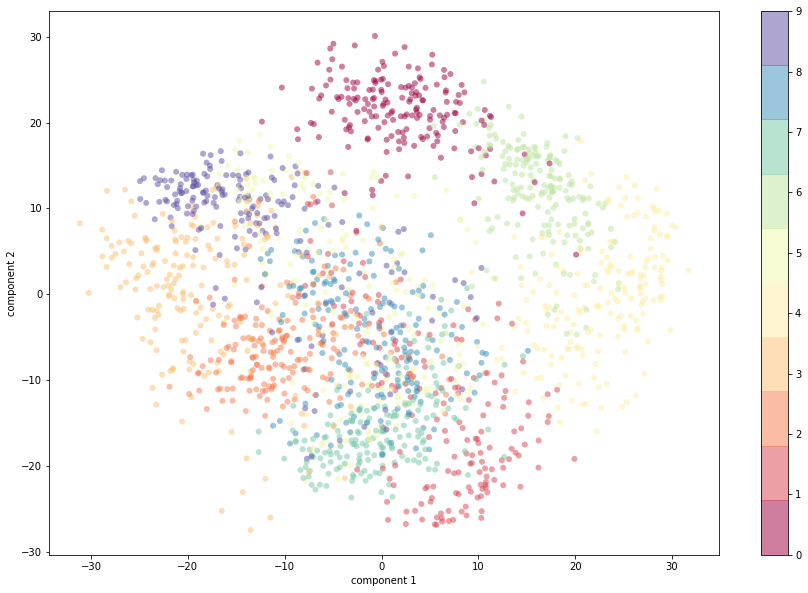

In [167]:
# TODO: Get the two first PCs
t1 = -T[:,0]
t2 = -T[:,1]

plt.figure(figsize=(15, 10))
plt.scatter(
    t1, t2, c=digits.target, edgecolor='none', alpha=0.5,
    cmap=plt.cm.get_cmap('Spectral', 10)
)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

### Task 3: Denoising: Remove noise from the noisy data

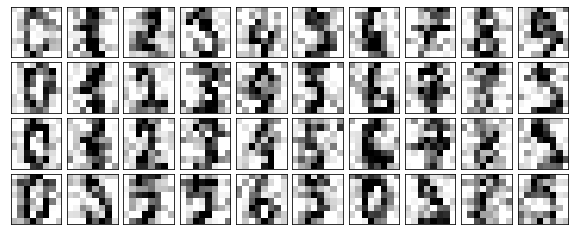

In [163]:
# Adding noise to the original data
X = digits.data
y = digits.target

np.random.seed(42)
noisy = np.random.normal(X, 4)

plot_digits(noisy)

Tips: 

* Decompose the noisy data using PCA 
* Reconstruct the data using just a few dominant components. For eg. check the variance plot 

Since the nature of the noise is more or less similar across all the digits, they are not the fearues with enough variance to discriminate between the digits. 

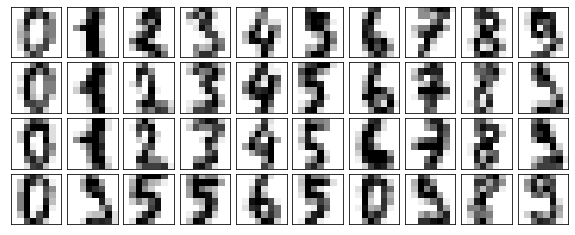

In [164]:
# TODO: Denoise X
X_denoised = X[:130, :] # From previous task: 130 components explain 75% of the variance - the rest explains the noise - we remove it
plot_digits(X_denoised)

### Task 4: Study the impact of normalization of the dataset before conducting PCA. Discuss if it is critical to normalize this particular data compared to the dataset in other notebooks

## All the above excercises can be done using the sklearn library as follows

In [165]:
from sklearn.decomposition import PCA


X = digits.data
y = digits.target

(1797, 64)
(1797, 2)


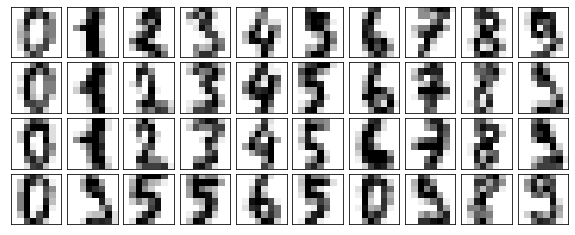

In [166]:
pca = PCA(2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(digits.data)

print(digits.data.shape)
print(projected.shape)
plot_digits(digits.data)

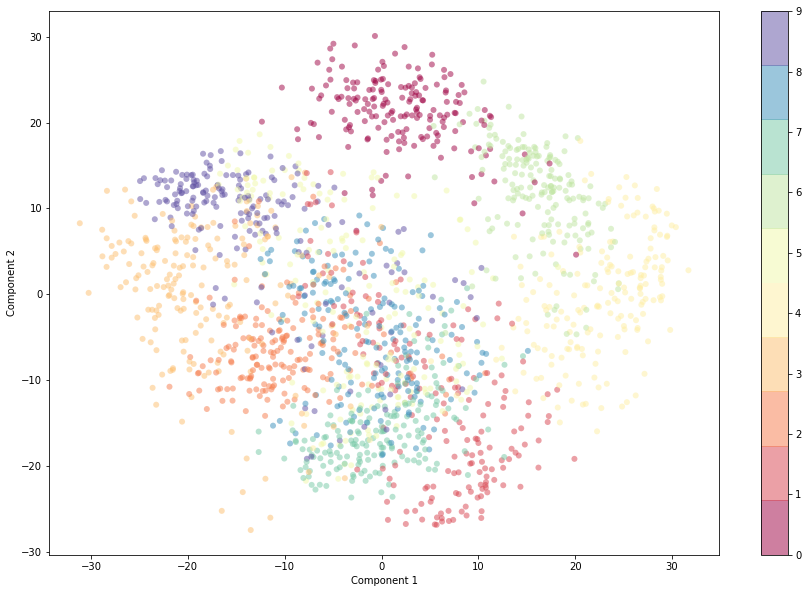

In [107]:
plt.figure(figsize=(15,10))
plt.scatter(
    projected[:, 0], projected[:, 1],
    c=digits.target, edgecolor='none', alpha=0.5,
    cmap=plt.cm.get_cmap('Spectral', 10)
)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar();

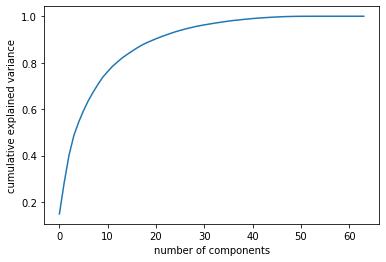

In [108]:
pca = PCA().fit(X)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

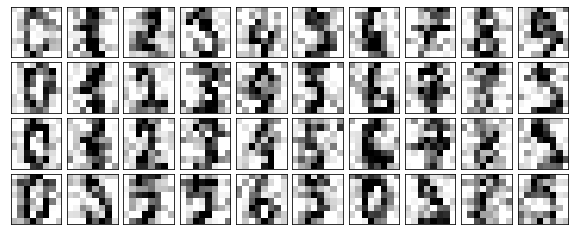

In [109]:
np.random.seed(42)

noisy = np.random.normal(digits.data, 4)
plot_digits(noisy)

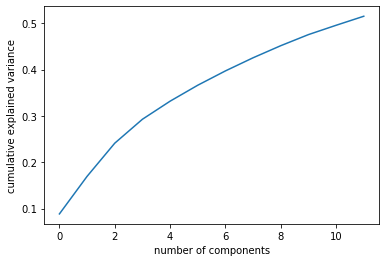

In [110]:
pca = PCA(0.50).fit(noisy) # 50% of the variance amounts to 12 principal components.

pca.n_components_
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

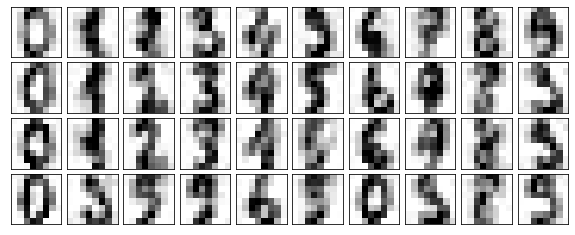

In [111]:
components = pca.transform(noisy)
filtered = pca.inverse_transform(components)
plot_digits(filtered)